<a href="https://colab.research.google.com/github/grace3999/PPs/blob/master/5_FIFI_image_CNN_transferlearn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import requests 
from multiprocessing.pool import ThreadPool
import time
import random
from shutil import copyfile
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [3]:
#path for FIFI cleaned and preprocessed data frame
path_FIFI = '/content/gdrive/My Drive/WIDS_FIFI_groupproject/generated_datasets/data_final.pkl'

#read in pkl file containing 
data = pd.read_pickle(path_FIFI)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)

print('Original data shape:\n', data.shape, '\n')

#clean data, combine 'sign/signal' and 'streetlight' 
data = data[data['FIFI_category'] != 'Community Walk']
data['FIFI_category'] = data['FIFI_category'].replace({'Needles/Dumping': 'Needles_Dumping', 'Sign/Signal': 'Sign_Signal_Light', 'Streetlight': 'Sign_Signal_Light'})

#we are only interested in FIFI requests that have a photo included with the request
print(data.shape)
data_photo = data[~data['Photo'].isna()]
print(data_photo.shape)

print(data_photo['FIFI_category'].value_counts())

Original data shape:
 (248815, 67) 

(248661, 67)
(183278, 67)
Needles_Dumping      40265
Other                34428
Grafitti             31749
Abnd_Vehicle         26656
Parking              25140
Pothole              13154
Sign_Signal_Light    11398
Clogged_Drain        427  
Vegetation           44   
Dead Animal          17   
Name: FIFI_category, dtype: int64


In [4]:
#create a directory for each category
try:
    os.mkdir('/tmp/FIFI_photos/')
except:
    pass

save_path = '/tmp/FIFI_photos/'

train_cats = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Sign_Signal_Light']

for cat in train_cats:
    if os.path.exists(os.path.join(save_path, cat)) == True:
      print(cat, " already exists")
    else:
      os.mkdir(os.path.join(save_path, cat))
      print(cat, " directory created")

Abnd_Vehicle  directory created
Grafitti  directory created
Needles_Dumping  directory created
Parking  directory created
Pothole  directory created
Sign_Signal_Light  directory created


In [6]:
#create function to get photo from url and save
def fetch_and_save(image_url_tupple):
    image_name, image_url = image_url_tupple
    #create file name for photo
    image_name = os.path.join(save_path_cat, image_name)  
    #get photo from url and save
    r = requests.get(image_url, allow_redirects=True)
    open(image_name, 'wb').write(r.content)

#use '/tmp/' for faster performance
save_path = '/tmp/FIFI_photos/'

#do each category individually, random select 1000 for each category (colab freezes at around 8000 downloads)
for cat in train_cats:

  size = 1000
  theads = 5
  save_path_cat = os.path.join(save_path, cat)
  random.seed(39)

  print(cat)
  cat_data = data_photo[data_photo['FIFI_category'] == cat].reset_index() 
  #get list of randomly selected indexes of specificed size
  random_index = random.sample(list(cat_data.index.values), size)
  cat_data_random = cat_data[cat_data.index.isin(random_index)].reset_index()

  i = 0
  while i < cat_data_random.shape[0]:
    if i%100 == 0:
      print(i)
    #run on multiple threads for faster performance, save each photo with 'service_request_number' for later indexing
    urls = list(zip([cat+'_'+str(x)+'.jpeg' for x in cat_data_random['Service_Request_Number'].iloc[i:i+theads]], cat_data_random['Photo'][i:i+theads]))
    ThreadPool(theads).imap_unordered(fetch_and_save, urls)
    i += theads

Abnd_Vehicle
0
100
200
300
400
500
600
700
800
900
Grafitti
0
100
200
300
400
500
600
700
800
900
Needles_Dumping
0
100
200
300
400
500
600
700
800
900
Parking
0
100
200
300
400
500
600
700
800
900
Pothole
0
100
200
300
400
500
600
700
800
900
Sign_Signal_Light
0
100
200
300
400
500
600
700
800
900


In [0]:
#create directories for training and testing 
project_dir = '/tmp/'

try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/training'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/testing'))
except OSError:
  pass


In [0]:
#create directories for train/test for each FIFI category 
photo_categories = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Sign_Signal_Light']

train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  try:
    os.mkdir(os.path.join(train_dir, cat))
  except OSError:
   print('cannot make directory for train: ', cat)
  try:
    os.mkdir(os.path.join(test_dir, cat))
  except OSError:
   print('cannot make directory for test: ', cat)

In [0]:
#function to split data into training and testing based on a specified split size
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)

In [10]:
photos_dir = '/tmp/FIFI_photos/'
train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  print(cat)
  source_dir = os.path.join(photos_dir, cat)
  train_dir_cat = os.path.join(train_dir, cat)
  test_dir_cat = os.path.join(test_dir, cat)

  split_size = .7
  start_time = time.time()
  split_data(source_dir, train_dir_cat, test_dir_cat, split_size)
  print("--- %s seconds ---" % (time.time() - start_time))


Abnd_Vehicle
--- 2.211167097091675 seconds ---
Grafitti
--- 1.1254515647888184 seconds ---
Needles_Dumping
--- 2.150331735610962 seconds ---
Parking
--- 1.8408453464508057 seconds ---
Pothole
--- 3.0785248279571533 seconds ---
Sign_Signal_Light
--- 2.6228630542755127 seconds ---


In [11]:
#download weights and import model to use for transfer learning
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

--2019-12-01 07:55:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  33.2MB/s    in 2.5s    

2019-12-01 07:55:16 (33.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense  (6, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


In [15]:
#train CNN using images from each category besides 'other'

TRAINING_DIR = '/tmp/cnn_cat_other/training/'
VALIDATION_DIR = '/tmp/cnn_cat_other/testing/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.)
#(rescale=1./255, zoom_range=0.3, rotation_range=50, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(VALIDATION_DIR,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 3114 images belonging to 6 classes.
Found 1338 images belonging to 6 classes.


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>.998):
      print("\nReached 99.8% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            verbose = 1)

#callbacks=[callbacks]

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
98/98 [==============================] - 174s 2s/step - loss: 0.3550 - acc: 0.8509 - val_loss: 0.2980 - val_acc: 0.8728
Epoch 2/20
98/98 [==============================] - 154s 2s/step - loss: 0.2577 - acc: 0.8914 - val_loss: 0.3100 - val_acc: 0.8727
Epoch 3/20
98/98 [==============================] - 152s 2s/step - loss: 0.2017 - acc: 0.9199 - val_loss: 0.3387 - val_acc: 0.8766
Epoch 4/20
76/98 [======================>.......] - ETA: 21s - loss: 0.1419 - acc: 0.9461

In [0]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

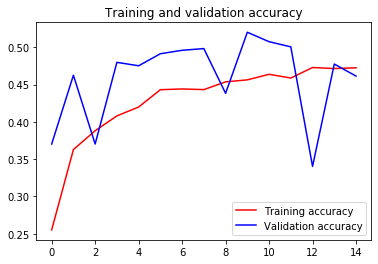

<Figure size 432x288 with 0 Axes>

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

In [0]:
# scaling test features
x_test /= 255.

# getting model predictions
test_predictions = model.predict(x_test)
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions = list(predictions.idxmax(axis=1))
test_labels = list(y_test)

# evaluate model performance
import model_evaluation_utils as meu
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)